<a href="https://colab.research.google.com/github/sergioGarcia91/ML_Carolina_Bays/blob/main/14_CNN_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
!pip install tables

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import multiprocessing
import joblib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Verificar si CUDA (GPU) está disponible
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    print("GPU no disponible, usando CPU.")

GPU disponible: Tesla T4


In [ ]:
pathSaveFiguras = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Manuscrito_FC/Figuras_Manuscrito/'

In [ ]:
device

device(type='cuda')

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change Font of the Figures

In [ ]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-11-11 18:31:25--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-11-11 18:31:25--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.03s   

2025-11-11 18:31:25 (25.0 MB/s) - ‘Times New Roman.ttf’ saved [834452/834452]



In [ ]:
import matplotlib.font_manager as fm

In [ ]:
# Path to the custom font
font_path = 'Times New Roman.ttf'

# Add the font to the Matplotlib font manager
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Get the font name to use in rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

In [ ]:
plt.rcParams['font.family'] = font_name

# Funtions

## get_rgb

In [ ]:
def get_rgb(tif):
  rgb_image = np.dstack((tif[3],
                         tif[2],
                         tif[1]))
  return rgb_image


## normalize

In [ ]:
def normalize(img, min_percent=5, max_percent=95):
  # Adjusts the image contrast using percentiles.
  p_min, p_max = np.percentile(img, (min_percent, max_percent))
  return np.clip((img - p_min) / (p_max - p_min), 0, 1)


## CNN model

In [ ]:
# 2. Definir la arquitectura del modelo con inicialización personalizada
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(7, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.ReLU(),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )

    self.fc_layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(128 * 16 * 16, 128),  # Ajuste de tamaño
      nn.ReLU(),
      nn.Linear(128, 10)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.fc_layers(x)
    return x

# 4. Función de entrenamiento
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # mover a GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validación después de cada época
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Guardar las métricas
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

# 5. Función de validación
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # mover a GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total
    val_loss /= len(val_loader)
    return val_loss, val_acc

## Predecir 1 imagen

In [ ]:
# Función para hacer la predicción de una imagen específica y mostrar el porcentaje de probabilidad
def predict_single_image(model, test_loader):
    model.eval()  # Establecer el modelo en modo de evaluación

    # Obtener un lote de imágenes del DataLoader
    data_iter = iter(test_loader)
    #images, labels = next(data_iter)


    # Seleccionar la imagen por el índice
    image = test_loader#images[image_index].unsqueeze(0)  # Añadir dimensión de batch size
    label = 'no label'#labels[image_index]

    # Mostrar la imagen original
    #print(f"Imagen real: {class_names[label]}")
    #imshow(images[image_index])

    # Hacer la predicción
    with torch.no_grad():
        output = model(image)
        predictions = torch.softmax(output, dim=1).cpu().numpy()[0]

    # Mostrar el gráfico de barras con las probabilidades
    #plot_value_array(predictions, label)

    # Mostrar la predicción del modelo
    predicted_label = np.argmax(predictions)
    predicted_prob = np.max(predictions) * 100  # Convertir a porcentaje
    #print(f"Predicción del modelo: {class_names[predicted_label]} ({predicted_prob:.2f}%)")
    return predictions, predicted_label, predicted_prob

In [ ]:
# Función para mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar la imagen
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Cambiar de [C, H, W] a [H, W, C]
    plt.show()

# Función para mostrar las predicciones como gráfico de barras con el porcentaje de probabilidad
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(2), class_names, rotation=45)
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')  # Predicción del modelo en rojo
    thisplot[true_label].set_color('blue')      # Etiqueta real en azul

    # Mostrar el porcentaje de probabilidad para cada clase
    for i in range(2):
        plt.text(i, predictions_array[i], f'{predictions_array[i]*100:.1f}%', ha='center', color='black')

# Load data

In [ ]:
path_save_h5 = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Dataset_h5'

h5_file = os.listdir(path_save_h5)
h5_file

['dataset_AOI_01_32x32.h5',
 'dataset_AOI_02_32x32.h5',
 'dataset_AOI_03_32x32.h5',
 'dataset_AOI_04_32x32.h5',
 'dataset_AOI_02_64x64.h5',
 'dataset_AOI_01_64x64.h5',
 'dataset_AOI_03_64x64.h5',
 'dataset_AOI_04_64x64.h5',
 'dataset_AOI_02_256x256.h5',
 'dataset_AOI_03_256x256.h5',
 'dataset_AOI_04_256x256.h5',
 'dataset_AOI_01_256x256.h5']

In [ ]:
img = 30000 # 99

# AOI
AOI_name = 'AOI_02'
AOI_ = h5py.File(os.path.join(path_save_h5, f'dataset_{AOI_name}_64x64.h5'), 'r')
AOI_

<HDF5 file "dataset_AOI_02_64x64.h5" (mode r)>

In [ ]:
AOI_[f'{AOI_name}_X'].shape

(94500, 7, 64, 64)

## Plot image

Image 30000


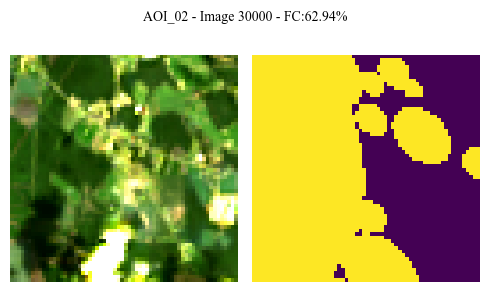

In [ ]:
print(f'Image {img}')
X_ = AOI_[f'{AOI_name}_X'][img]
Y_ = AOI_[f'{AOI_name}_y'][img]
P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]

fig, ax = plt.subplots(figsize=(5, 3), nrows=1, ncols=2)
ax[0].imshow(normalize(get_rgb(X_)))  # Apply normalization
ax[0].axis('off')
ax[1].imshow(Y_, vmin=0, vmax=1)
ax[1].axis('off')

plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
plt.tight_layout()
plt.show()

# X - y df

In [ ]:
X_1 = AOI_[f'{AOI_name}_X'][img]
y_1 = AOI_[f'{AOI_name}_y'][img]

X_1_r = np.reshape(X_1, (7, -1)).T
y_1_r = y_1.reshape(-1,1)

# 64*64 = 4096
print(X_1_r.shape)
print(y_1_r.shape)

(4096, 7)
(4096, 1)


# Predicting CNN Model

## Load models

In [ ]:
path_models = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models/'

models_list = os.listdir(path_models)
models_list = [model for model in models_list if model.endswith('.pth')]
models_list

['model_CNN_CPU_01.pth',
 'model_CNN_GPU_01.pth',
 'model_CNN_GPU_02.pth',
 'model_CNN_GPU_03.pth',
 'model_Unet_7ch_GPU_01.pth',
 'model_Unet_7ch_GPU_01_v2.pth',
 'model_Unet_7ch_GPU_02_v2.pth',
 'model_Unet_7ch_GPU_02.pth',
 'model_Unet_7ch_GPU_03.pth',
 'model_Unet_7ch_GPU_03_v2.pth',
 'model_Unet_7ch_GPU_04_v2.pth',
 'model_Unet_7ch_GPU_04.pth',
 'model_Unet_12ch_GPU_01.pth',
 'model_Unet_v2_7ch_ML_GPU_01.pth',
 'model_Unet_v2_7ch_bandas_GPU_01.pth']

In [ ]:
path_modelo = os.path.join(path_models, 'model_CNN_GPU_03.pth')#models_list[3])
path_modelo

# Inicializar el modelo y aplicar la inicialización personalizada
model = CNN().to(device) # mover a GPU
model.load_state_dict(torch.load(path_modelo))
# Si se usa GPU
#model.load_state_dict(torch.load('modelo_pesos.pth', map_location=torch.device('cuda')))
#model.eval()  # si es para inferencia -- > ya esta en la fun predecir

<All keys matched successfully>

In [ ]:
# Definir las clases
class_names = ['No FC', 'FC']

In [ ]:
X_test = torch.tensor(AOI_[f'{AOI_name}_X'][img])
X_test = X_test.unsqueeze(0) # Añadir dimensión de batch size
X_test = X_test.to(device) # mover a GPU

print(X_test.shape)

torch.Size([1, 7, 64, 64])


In [ ]:
# Ejemplo de cómo usar la función para predecir la imagen en el índice 0 del lote
predict = predict_single_image(model, X_test)

predict

(array([1.06860556e-01, 8.93137395e-01, 3.82512980e-07, 2.84384782e-07,
        3.66395625e-07, 2.29846080e-07, 3.39620186e-07, 2.76460753e-07,
        1.68933425e-07, 1.48112903e-07], dtype=float32),
 np.int64(1),
 np.float32(89.313736))

In [ ]:
np.round(predict[0], 2)

array([0.11, 0.89, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
      dtype=float32)

## Plot predictions

In [ ]:
probs = predict[0]  # array con probabilidades para todas las clases


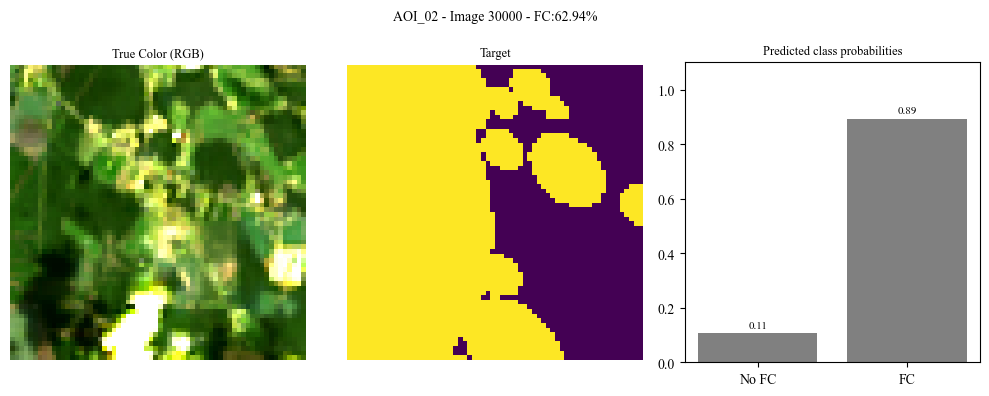

In [ ]:
# Obtener índices de las 2 clases más probables
#top2_idx = np.argsort(probs)[-2:][::-1]  # orden descendente

# Obtener nombres o etiquetas de clases si tienes (si no, serán solo índices)
#class_names = ['No FC', 'FCClase 1', 'Clase 2', ..., 'Clase N']  # reemplaza si tienes etiquetas reales
#top2_names = [class_names[i] for i in top2_idx]
#top2_probs = [probs[i] for i in top2_idx]
# Asegura el orden manualmente: ['No FC', 'FC']
top2_names = ['No FC', 'FC']
top2_probs = [probs[0], probs[1]]  # índice 0 = No FC, índice 1 = FC

# Graficar todo como antes pero usando histograma en ax[2]
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=3)

ax[0].imshow(normalize(get_rgb(X_)))
ax[0].axis('off')
ax[0].set_title('True Color (RGB)', fontsize=9)

ax[1].imshow(Y_, vmin=0, vmax=1)
ax[1].axis('off')
ax[1].set_title('Target', fontsize=9)

# En ax[2], mostrar histograma de las dos clases más probables
ax[2].bar(top2_names, top2_probs, color='gray')
ax[2].set_ylim([0, 1.1])
ax[2].set_title('Predicted class probabilities', fontsize=9)
for i, v in enumerate(top2_probs):
    ax[2].text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=8)

plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
plt.tight_layout()
plt.show()


# Loop A2

In [ ]:
# AOI
AOI_name = 'AOI_02'
AOI_ = h5py.File(os.path.join(path_save_h5, f'dataset_{AOI_name}_64x64.h5'), 'r')
AOI_[f'{AOI_name}_X'].shape

(94500, 7, 64, 64)

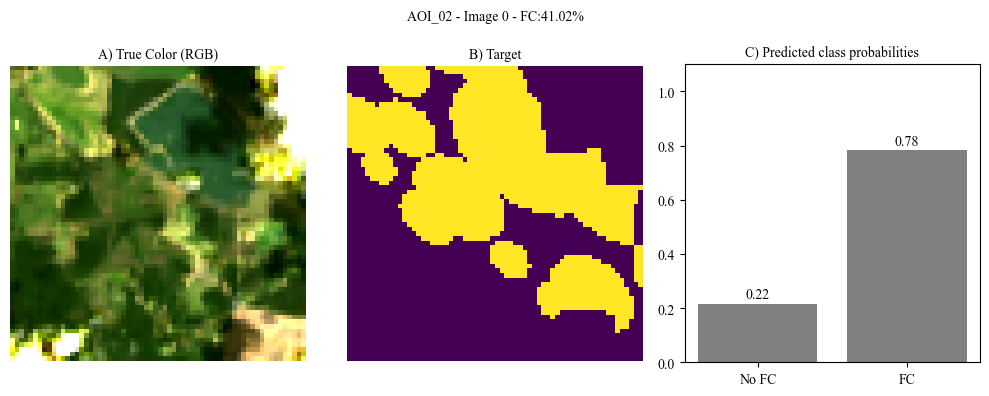

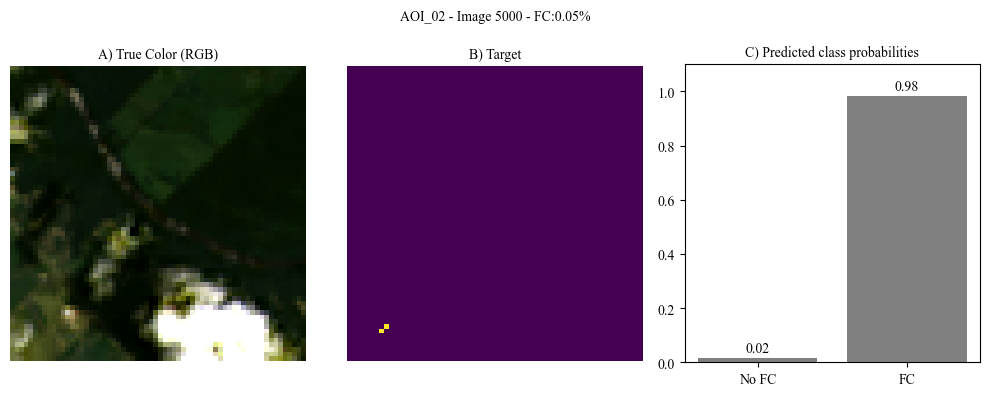

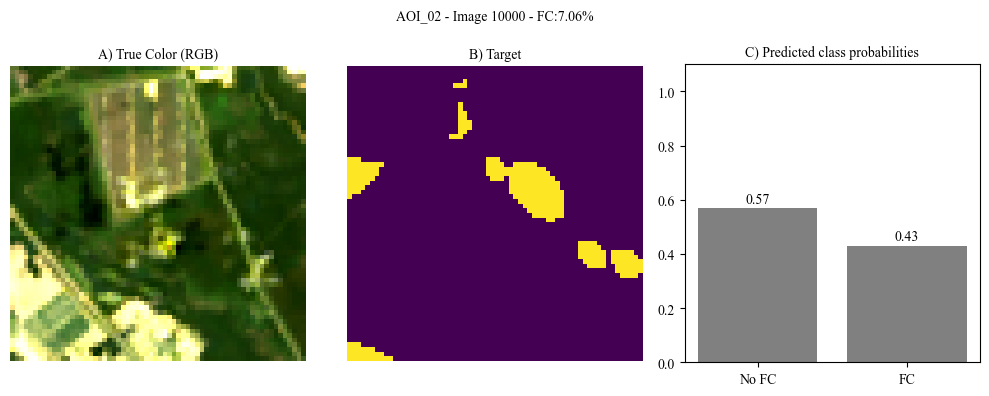

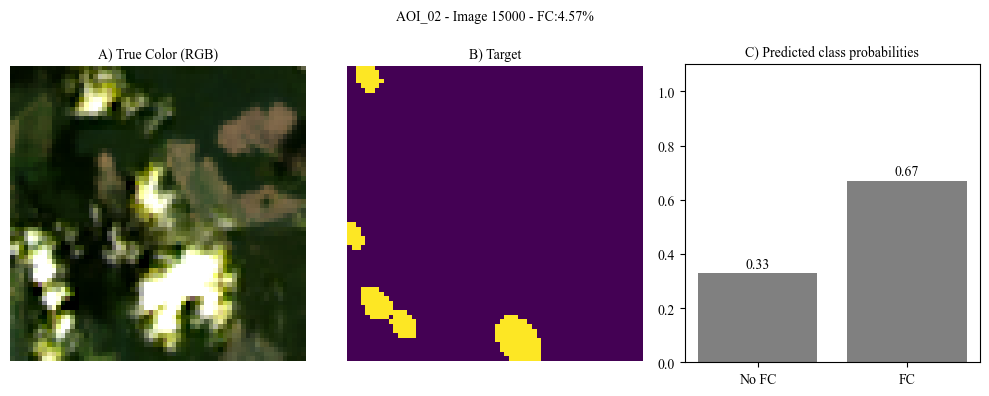

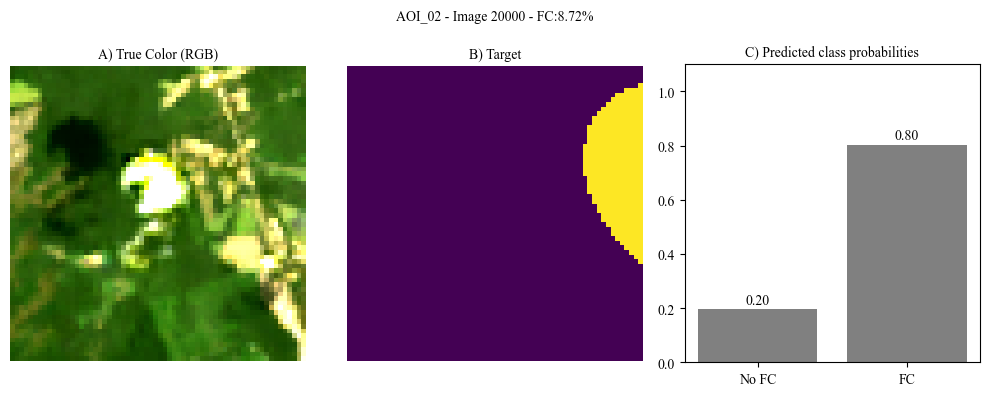

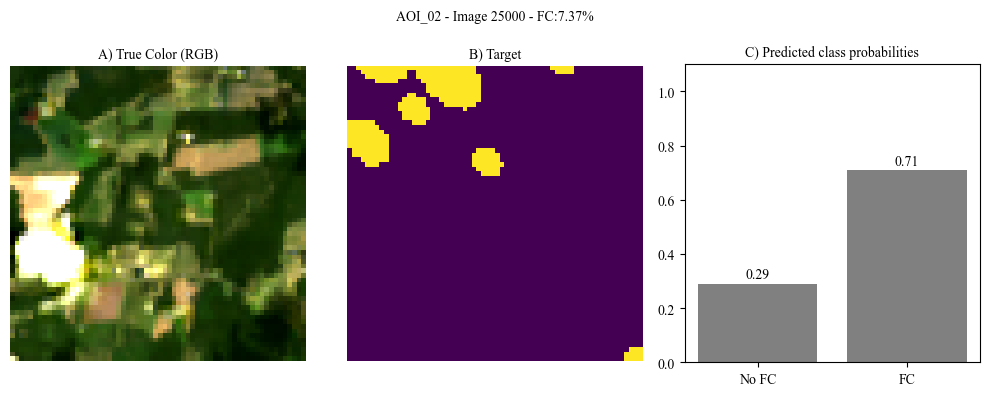

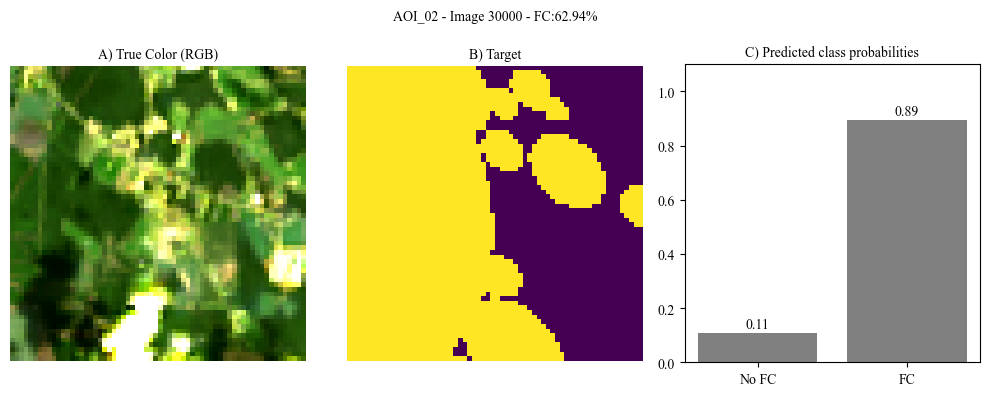

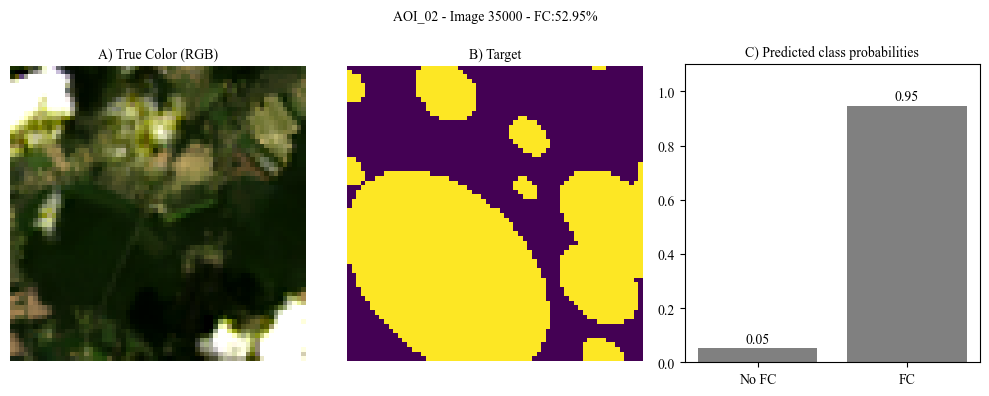

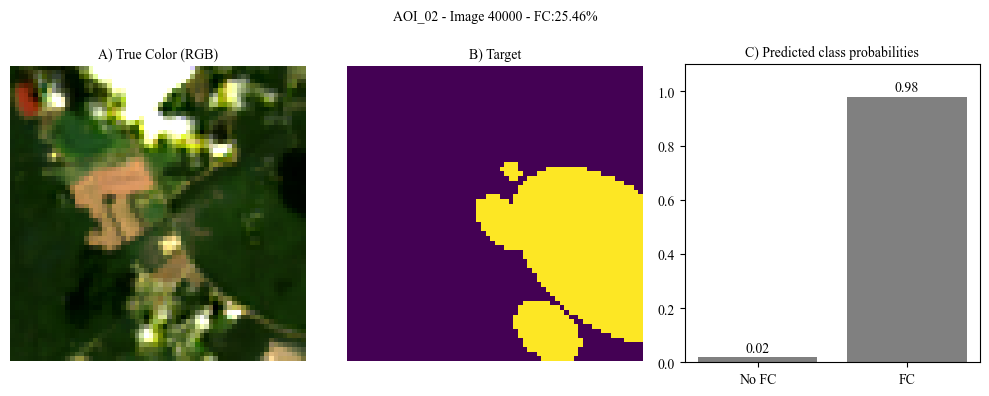

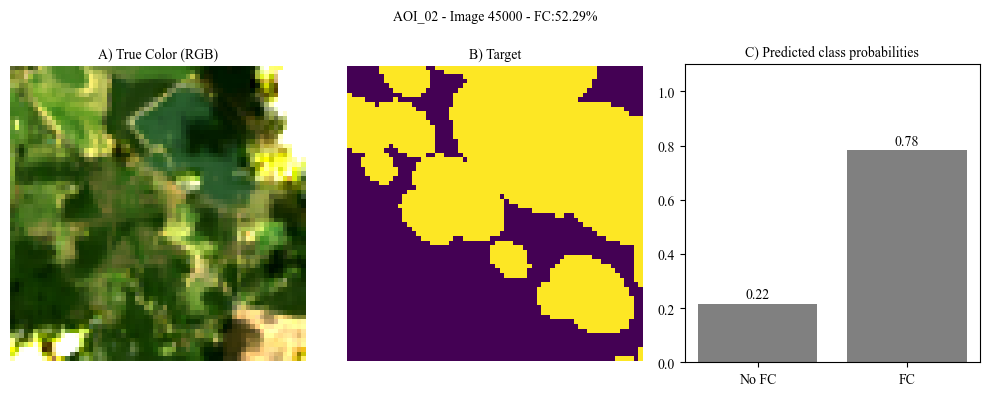

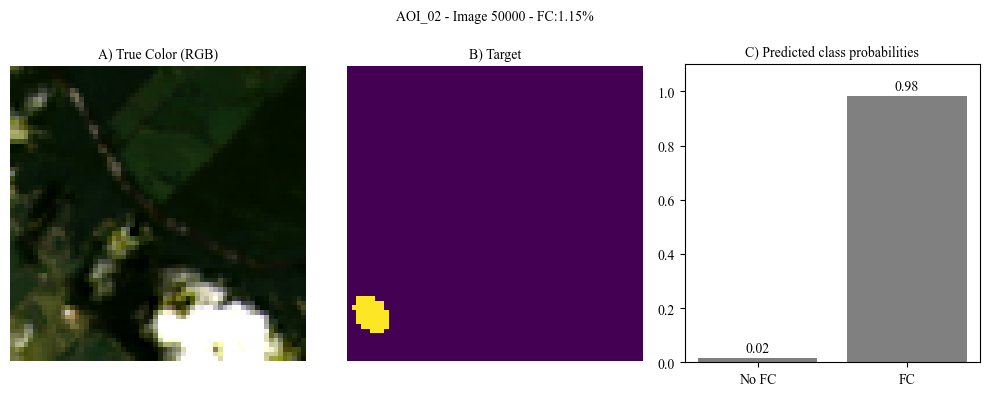

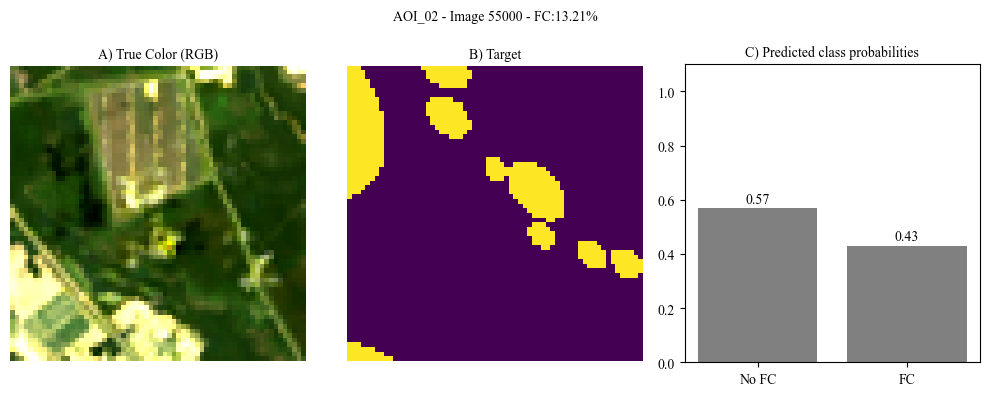

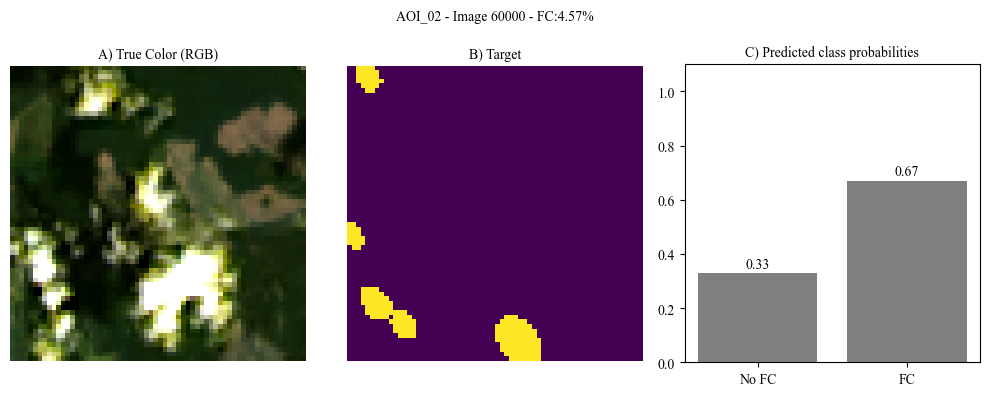

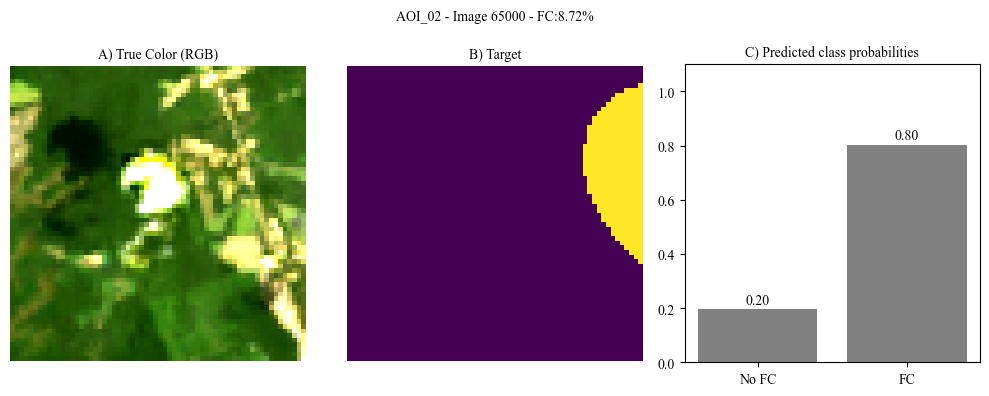

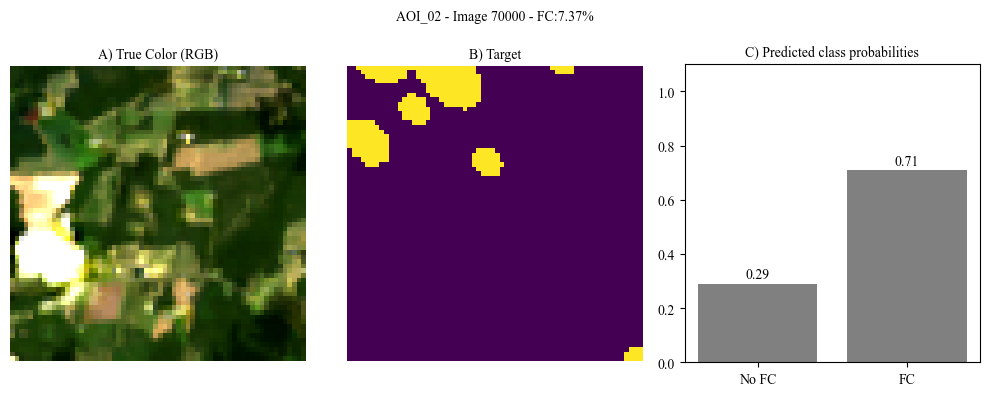

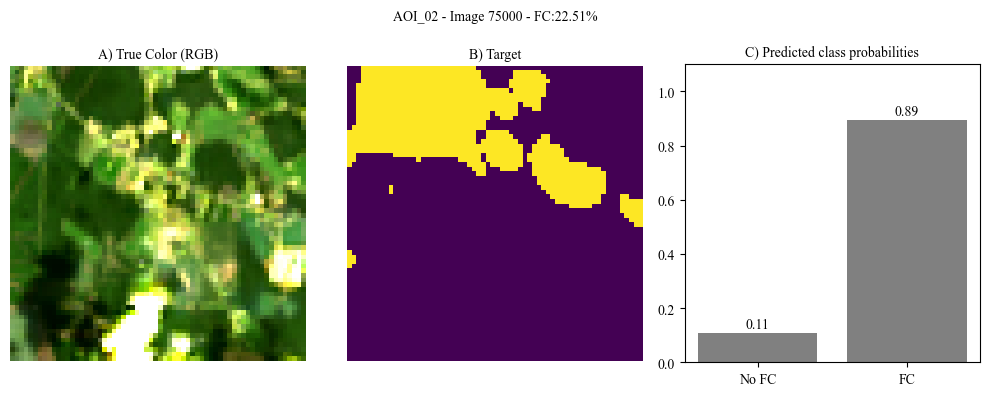

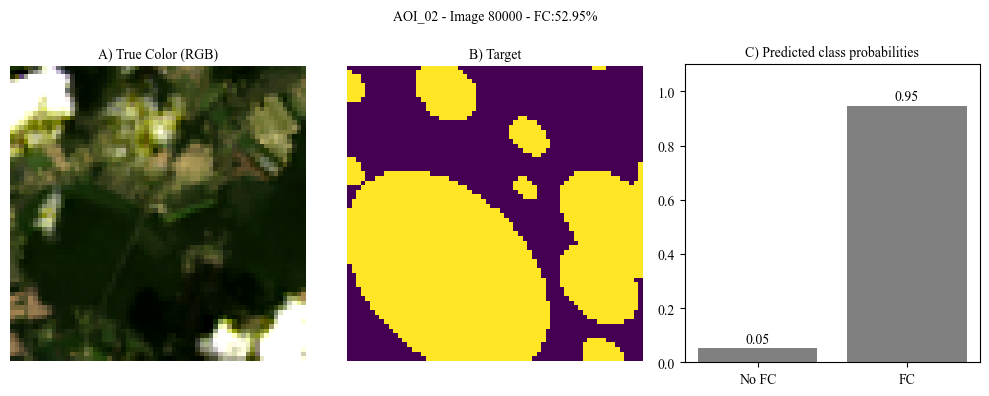

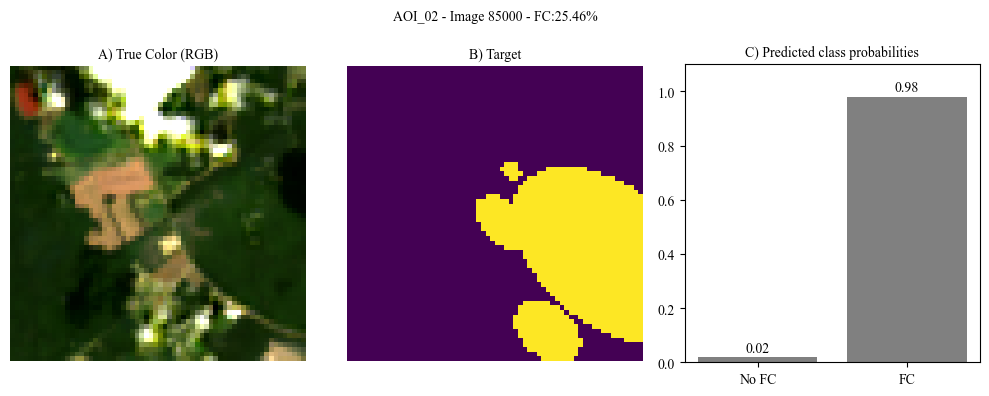

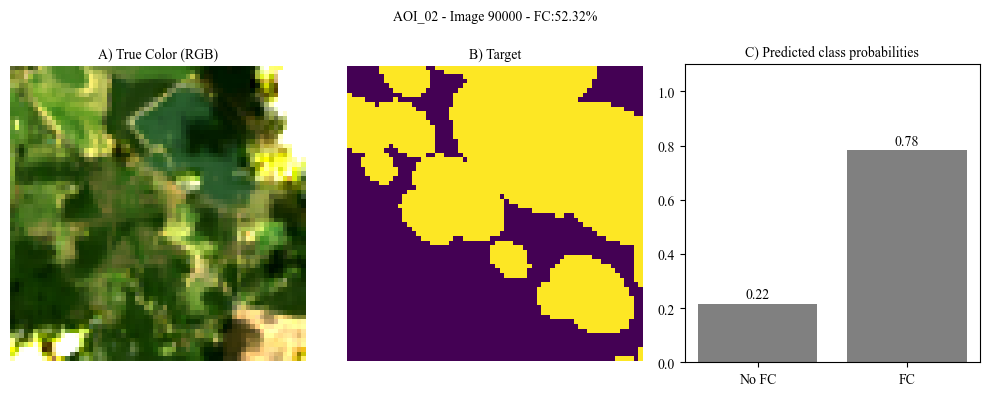

In [ ]:
imgs_of_interests = np.arange(0, AOI_[f'{AOI_name}_X'].shape[0], 5000)

for img in imgs_of_interests:
  X_ = AOI_[f'{AOI_name}_X'][img]
  Y_ = AOI_[f'{AOI_name}_y'][img]
  P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]
  X_test = torch.tensor(AOI_[f'{AOI_name}_X'][img])
  X_test = X_test.unsqueeze(0) # Añadir dimensión de batch size
  X_test = X_test.to(device) # mover a GPU

  predict = predict_single_image(model, X_test)

  probs = predict[0]  # array con probabilidades para todas las clases
  # Obtener índices de las 2 clases más probables
  #top2_idx = np.argsort(probs)[-2:][::-1]  # orden descendente

  # Obtener nombres o etiquetas de clases si tienes (si no, serán solo índices)
  #class_names = ['No FC', 'FCClase 1', 'Clase 2', ..., 'Clase N']  # reemplaza si tienes etiquetas reales
  #top2_names = [class_names[i] for i in top2_idx]
  #top2_probs = [probs[i] for i in top2_idx]
  # Asegura el orden manualmente: ['No FC', 'FC']
  top2_names = ['No FC', 'FC']
  top2_probs = [probs[0], probs[1]]  # índice 0 = No FC, índice 1 = FC

  # Graficar todo como antes pero usando histograma en ax[2]
  fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=3)

  ax[0].imshow(normalize(get_rgb(X_)))
  ax[0].axis('off')
  ax[0].set_title('A) True Color (RGB)', fontsize=10)

  ax[1].imshow(Y_, vmin=0, vmax=1)
  ax[1].axis('off')
  ax[1].set_title('B) Target', fontsize=10)

  # En ax[2], mostrar histograma de las dos clases más probables
  ax[2].bar(top2_names, top2_probs, color='gray')
  ax[2].set_ylim([0, 1.1])
  ax[2].set_title('C) Predicted class probabilities', fontsize=10)
  for i, v in enumerate(top2_probs):
      ax[2].text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)

  plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
  plt.tight_layout()

  if img == 0:
    plt.savefig((pathSaveFiguras + f'Figura_CNN_{AOI_name}.png'),
            format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

  plt.show()

  print('\n')



# Loop A4

In [ ]:
# AOI
AOI_name = 'AOI_04'
AOI_ = h5py.File(os.path.join(path_save_h5, f'dataset_{AOI_name}_64x64.h5'), 'r')
AOI_[f'{AOI_name}_X'].shape

(94500, 7, 64, 64)

In [ ]:
AOI_['AOI_04_y'][0].sum()

np.float32(0.0)

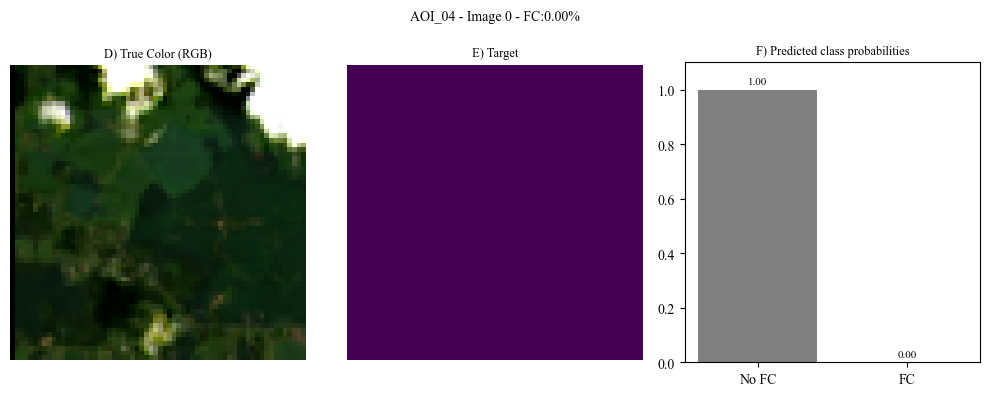

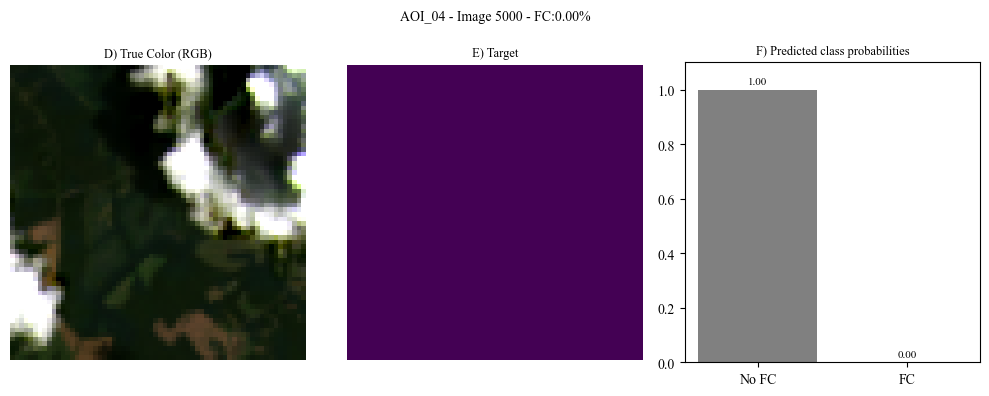

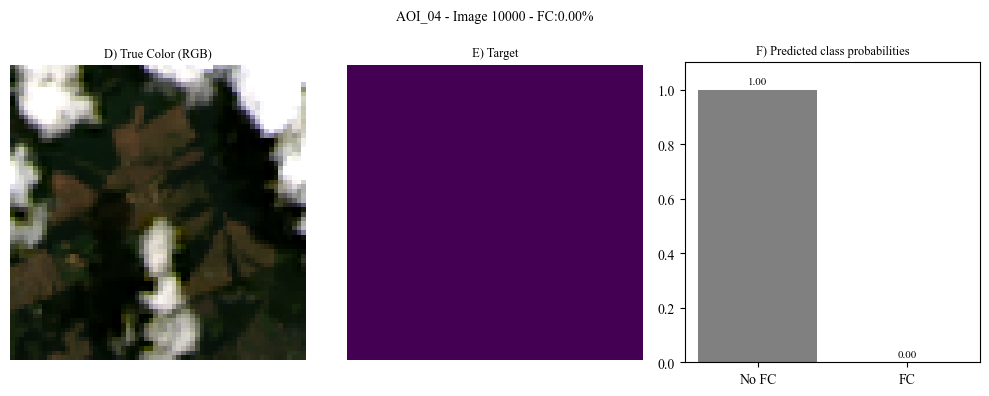

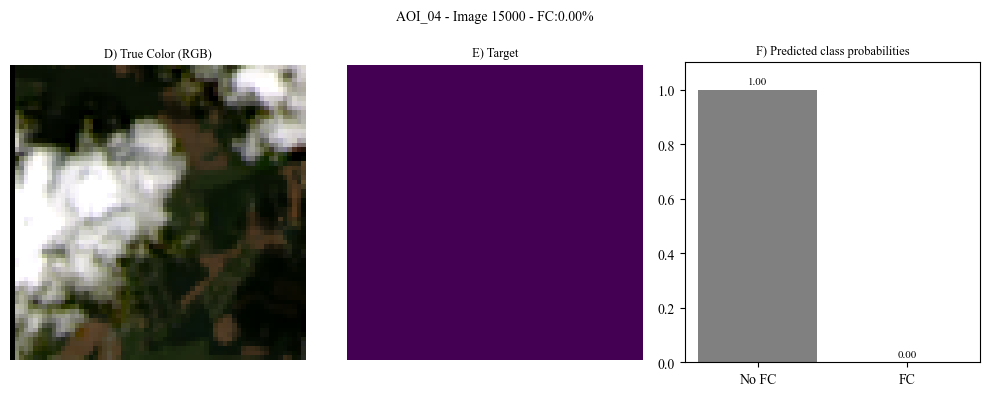

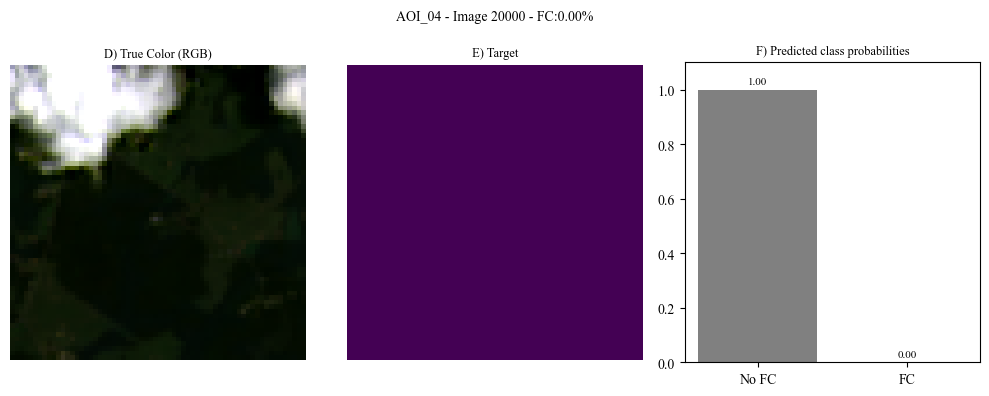

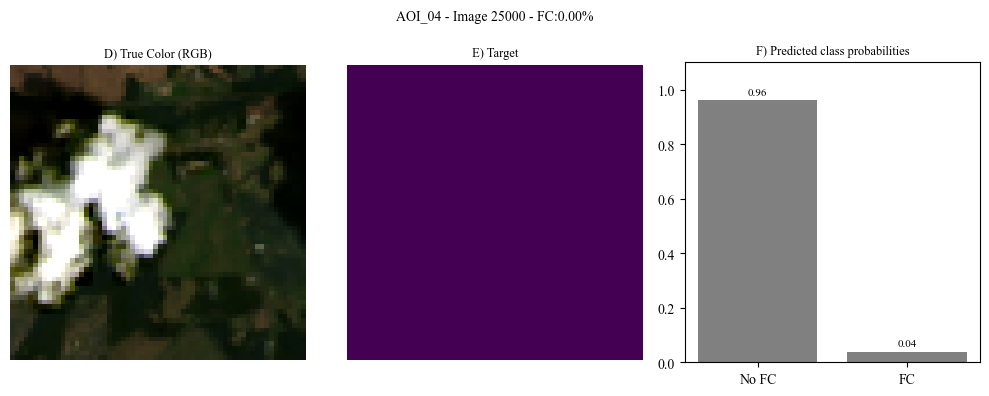

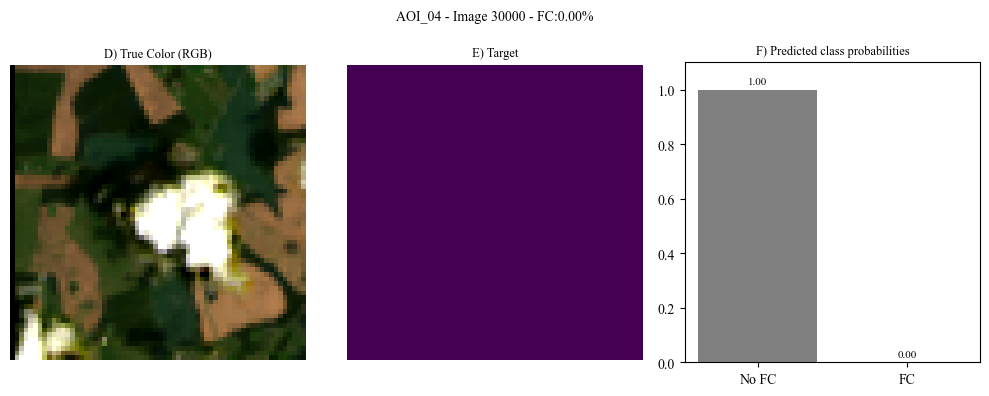

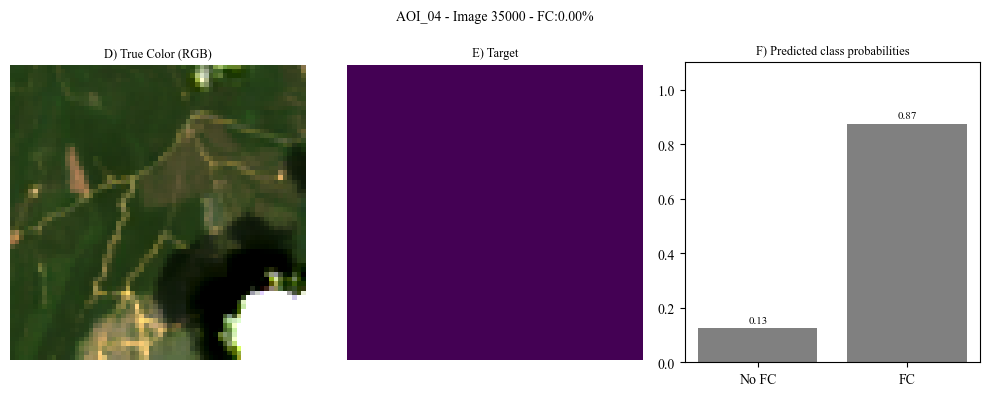

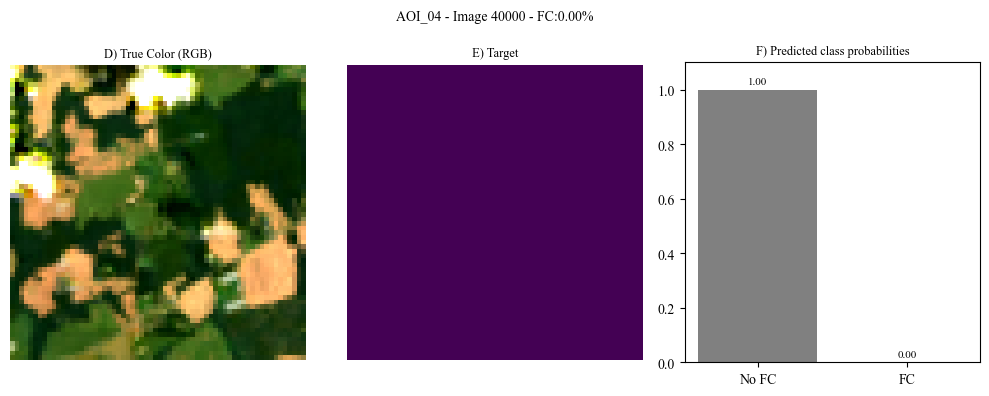

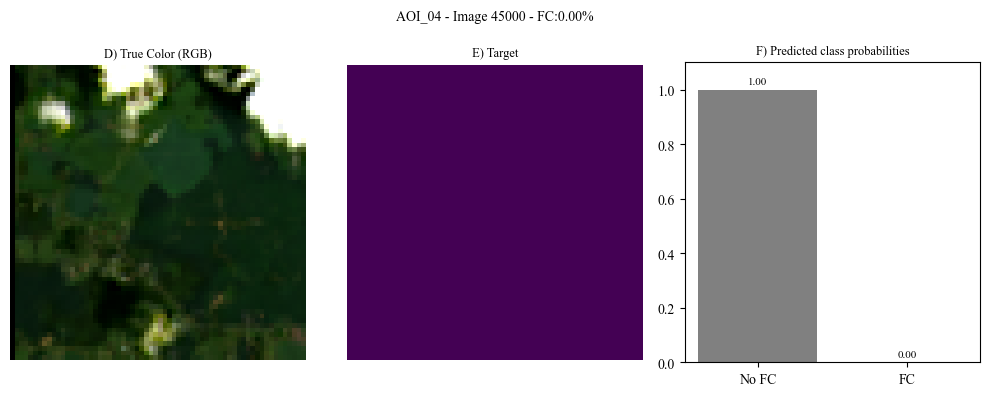

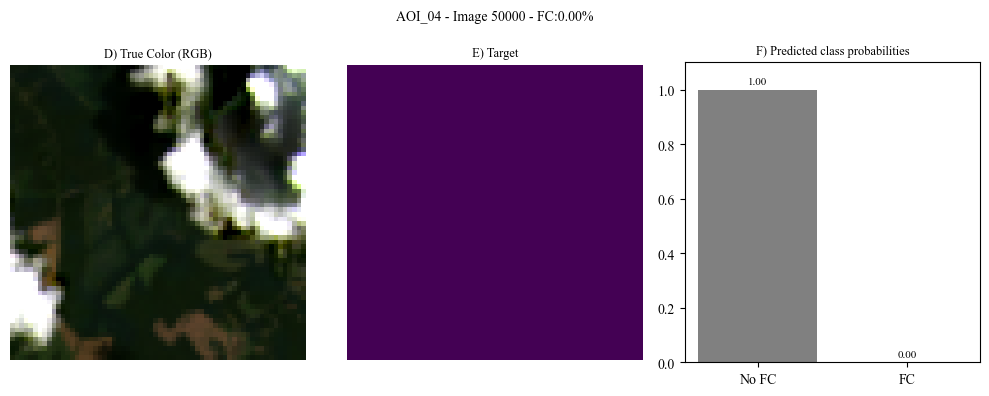

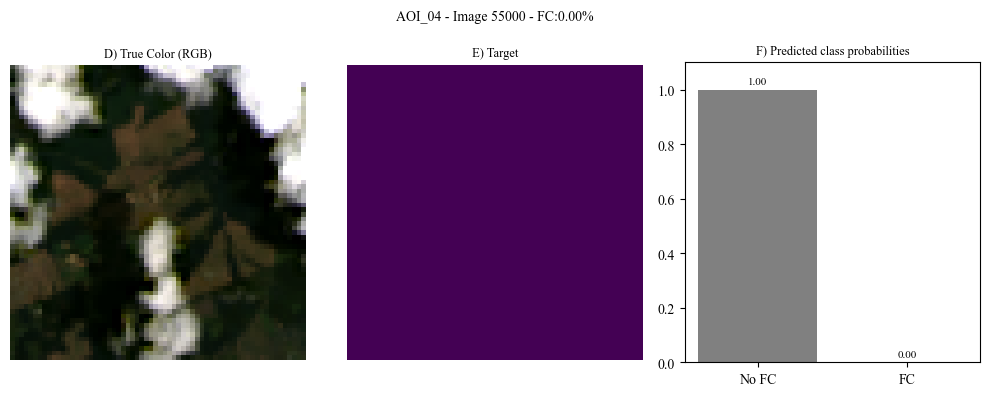

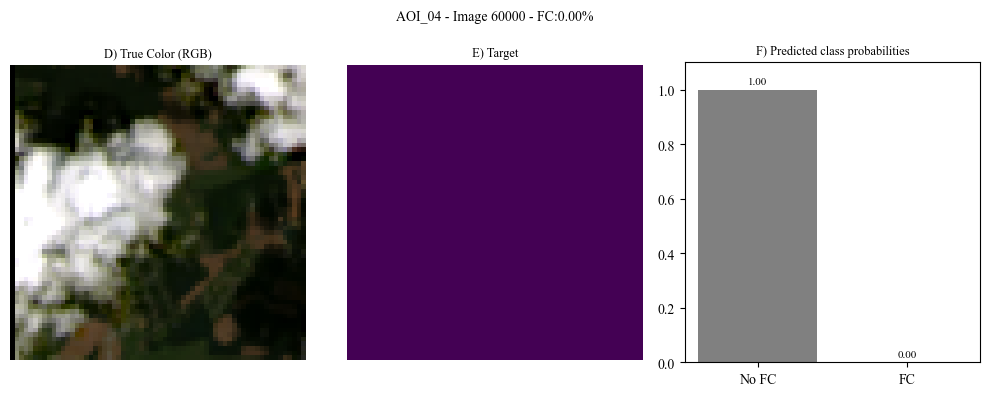

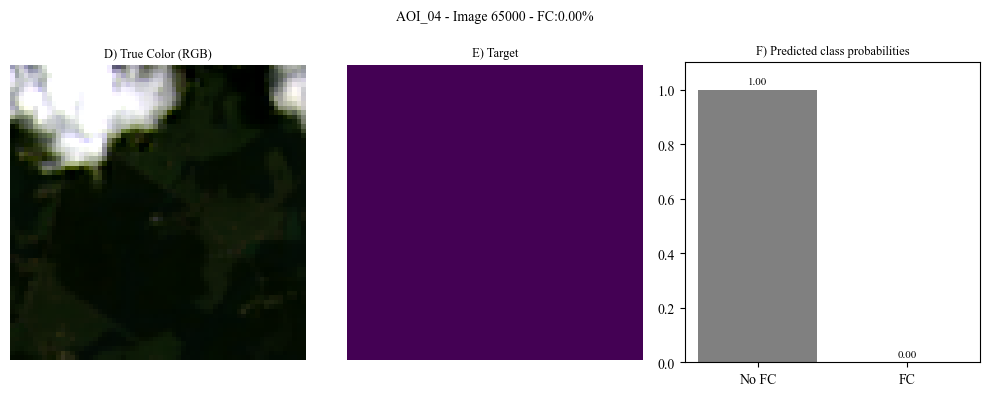

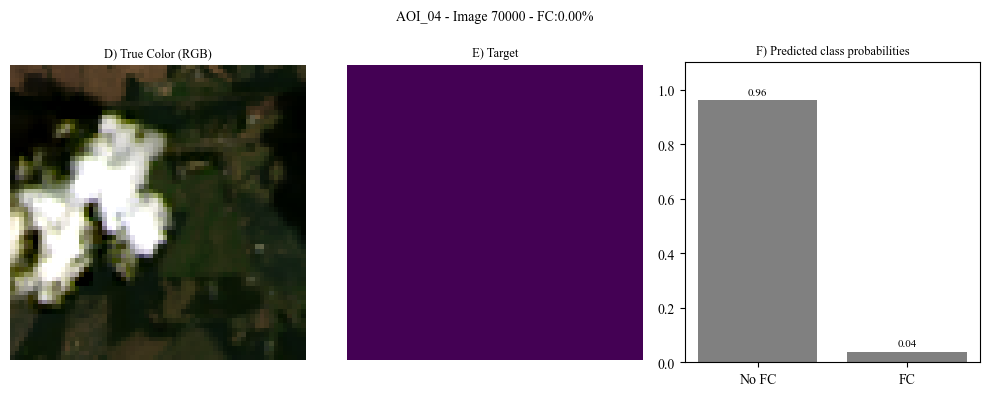

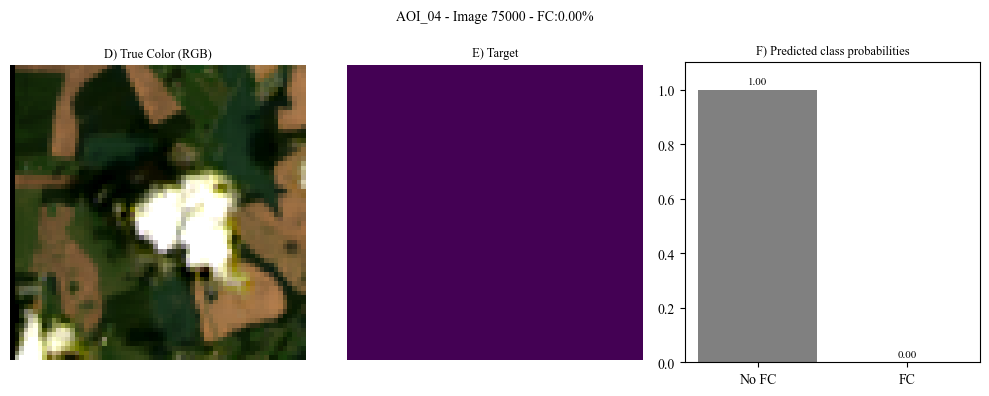

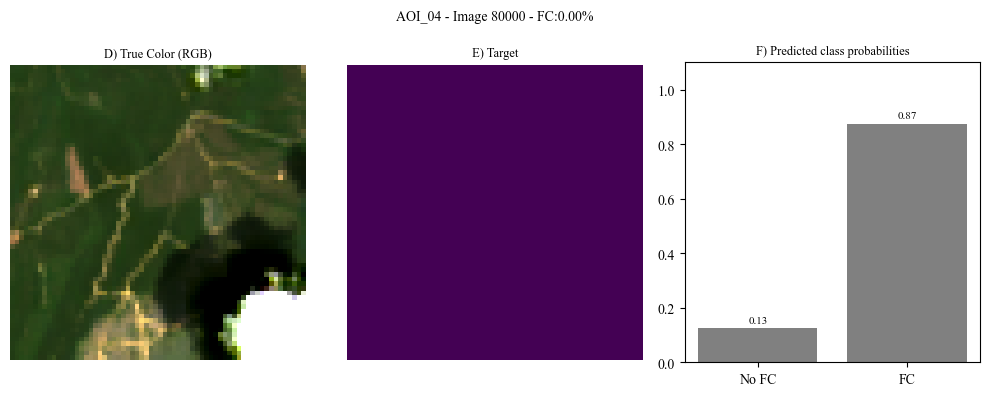

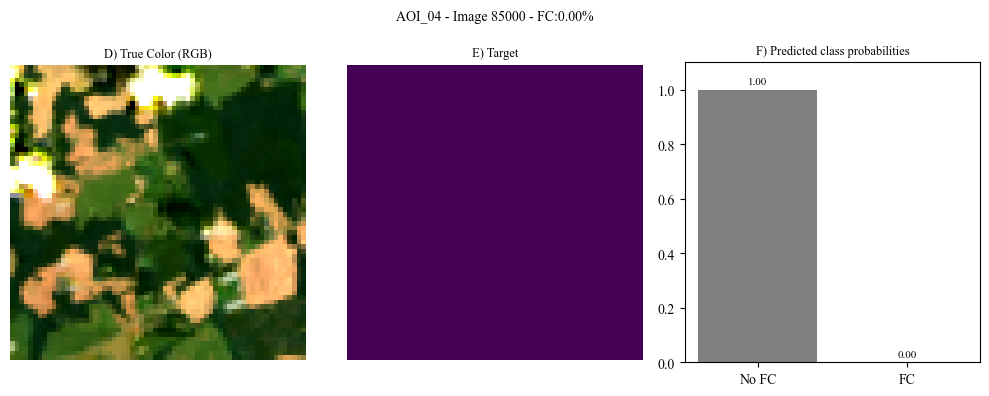

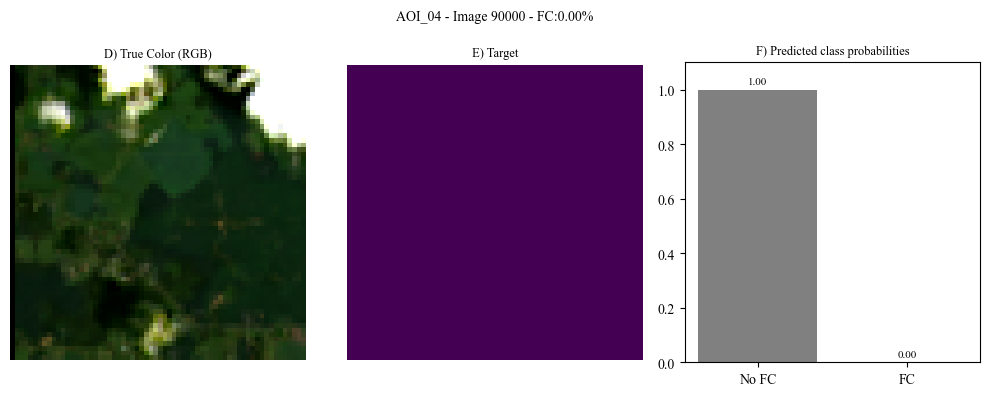

In [ ]:
imgs_of_interests = np.arange(0, AOI_[f'{AOI_name}_X'].shape[0], 5000)

for img in imgs_of_interests:
  X_ = AOI_[f'{AOI_name}_X'][img]
  Y_ = AOI_[f'{AOI_name}_y'][img]
  P_ = AOI_[f'{AOI_name}_FC_percentaje'][img]
  X_test = torch.tensor(AOI_[f'{AOI_name}_X'][img])
  X_test = X_test.unsqueeze(0) # Añadir dimensión de batch size
  X_test = X_test.to(device) # mover a GPU

  predict = predict_single_image(model, X_test)

  probs = predict[0]  # array con probabilidades para todas las clases
  # Obtener índices de las 2 clases más probables
  #top2_idx = np.argsort(probs)[-2:][::-1]  # orden descendente

  # Obtener nombres o etiquetas de clases si tienes (si no, serán solo índices)
  #class_names = ['No FC', 'FCClase 1', 'Clase 2', ..., 'Clase N']  # reemplaza si tienes etiquetas reales
  #top2_names = [class_names[i] for i in top2_idx]
  #top2_probs = [probs[i] for i in top2_idx]
  # Asegura el orden manualmente: ['No FC', 'FC']
  top2_names = ['No FC', 'FC']
  top2_probs = [probs[0], probs[1]]  # índice 0 = No FC, índice 1 = FC

  # Graficar todo como antes pero usando histograma en ax[2]
  fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=3)

  ax[0].imshow(normalize(get_rgb(X_)))
  ax[0].axis('off')
  ax[0].set_title('D) True Color (RGB)', fontsize=9)

  ax[1].imshow(Y_, vmin=0, vmax=1)
  ax[1].axis('off')
  ax[1].set_title('E) Target', fontsize=9)

  # En ax[2], mostrar histograma de las dos clases más probables
  ax[2].bar(top2_names, top2_probs, color='gray')
  ax[2].set_ylim([0, 1.1])
  ax[2].set_title('F) Predicted class probabilities', fontsize=9)
  for i, v in enumerate(top2_probs):
      ax[2].text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=8)

  plt.suptitle(f'{AOI_name} - Image {img} - FC:{P_:.2f}%', fontsize=10)
  plt.tight_layout()

  if img == 85000:
    plt.savefig((pathSaveFiguras + f'Figura_CNN_{AOI_name}.png'),
            format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

  plt.show()

  print('\n')



# End